# BRD4 Inhibitors Conformers

In [1]:
%load_ext autoreload
%autoreload 2

### Libraries

In [2]:
import sys
sys.path.append("..")

In [3]:
import open3d as o3d
import numpy as np
import seaborn as sns
import pandas as pd

import re, os
from io import StringIO

from tqdm.auto import trange

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools

import ipywidgets as widgets

from spyrmsd import molecule, rmsd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-08-20 10:53:27,023 - __init__ - Enabling RDKit 2021.03.3 jupyter extensions


In [4]:
from utils import show_molecule_idx, show_conformer_idx, show_all_conformers
from utils import AlignShow

## BRD4 Inhibitors

### Load Molecules

Load all BRD4 inhibitors as SDF and PCD files:

In [5]:
path = "ligands/BRD4"
files = [os.path.join(path, f) for f in os.listdir(path) if os.path.splitext(f)[-1] == ".sdf" and os.path.splitext(f)[0][-4:] == "tran"]

# Sort BRD4 ligand files by number
r = re.compile("\d{1,2}")
files.sort(key=lambda f: int(r.search(os.path.basename(f)).group()))

mols = []
pcds = []
for f in files:
    s = Chem.SDMolSupplier(f)
    mol = next(s)
    mols.append(mol)

    pcd = o3d.io.read_point_cloud(f.replace(".sdf", ".pcd"))
    pcds.append(pcd)

print(mols)

[<rdkit.Chem.rdchem.Mol object at 0x7efd37df3170>, <rdkit.Chem.rdchem.Mol object at 0x7efd37df3120>, <rdkit.Chem.rdchem.Mol object at 0x7efd37dea940>, <rdkit.Chem.rdchem.Mol object at 0x7efd37df31c0>, <rdkit.Chem.rdchem.Mol object at 0x7efd37df3210>, <rdkit.Chem.rdchem.Mol object at 0x7efd37df3260>, <rdkit.Chem.rdchem.Mol object at 0x7efd37df32b0>, <rdkit.Chem.rdchem.Mol object at 0x7efd37df3300>, <rdkit.Chem.rdchem.Mol object at 0x7efd37df3350>, <rdkit.Chem.rdchem.Mol object at 0x7efd37df33a0>]


In [6]:
_ = widgets.interact(lambda index: show_molecule_idx(index, mols), index=widgets.IntSlider(min=0, max=len(mols)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=9), Output()), _dom_classes=('widget-interac…

### Generate Conformers

In [7]:
# Create conformers for a given molecule
molID = 9
cmol = mols[molID]
cmol = Chem.AddHs(cmol)
cids = AllChem.EmbedMultipleConfs(cmol, numConfs=10)

_ = widgets.interact(show_conformer_idx, mol=widgets.fixed(cmol), idx=(0, cmol.GetNumConformers()-1))

interactive(children=(IntSlider(value=4, description='idx', max=9), Output()), _dom_classes=('widget-interact'…

In [8]:
show_all_conformers(cmol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The generated conformers can now be saved in a SDF file:

In [9]:
# Save conformers to separate files
for i in range(cmol.GetNumConformers()):
    with Chem.SDWriter(os.path.join(path, f"conf_{i}.sdf")) as w:
        w.write(cmol, confId=i)
        
n_conf_minus_one = cmol.GetNumConformers() - 1

Given that `molgrid` installed from PyPI is incompatible with `openbabel`, we need to run `molgrid_to_pcd` within a Singularity container in order to generate PCD files:

In [10]:
!ls ligands/BRD4 | grep conf

conf_0.pcd
conf_0.sdf
conf_1.pcd
conf_1.sdf
conf_2.pcd
conf_2.sdf
conf_3.pcd
conf_3.sdf
conf_4.pcd
conf_4.sdf
conf_5.pcd
conf_5.sdf
conf_6.pcd
conf_6.sdf
conf_7.pcd
conf_7.sdf
conf_8.pcd
conf_8.sdf
conf_9.pcd
conf_9.sdf


In [11]:
%%bash -s "$path" "$n_conf_minus_one"

# Python variable path passed to bash
# Can be accessed with $1

# Python variable n_conf_minus_one passed to bash
# Can be accessed with $2

# Unfortunately molgrid does not work well with pybel
# molgrid_to_pcd needs to run within a Singularity container
# (RDKit and molgrid compiled from source!)
# See https://github.com/gnina/libmolgrid/issues/62

for CONF in $(seq 0 $2)
do
    singularity run --nv --app python ../development/densitymatch.sif \
        ../molgrid_to_pcd.py ${PWD}/${1}/conf_${CONF}.sdf -o ${PWD}/${1}/conf_${CONF}.pcd \
            --ligmap ${PWD}/../files/ligmap
done

In [12]:
!ls ligands/BRD4 | grep "conf.*\.pcd"

conf_0.pcd
conf_1.pcd
conf_2.pcd
conf_3.pcd
conf_4.pcd
conf_5.pcd
conf_6.pcd
conf_7.pcd
conf_8.pcd
conf_9.pcd


We can finally load the PCD files for the conformers:

In [13]:
cpcds = []
cmols = []

files = [os.path.join(path, f"conf_{i}.pcd") for i in range(cmol.GetNumConformers())]

print(files)

for f in files:
    pcd = o3d.io.read_point_cloud(f)
    cpcds.append(pcd)

    s = Chem.SDMolSupplier(f.replace(".pcd", ".sdf"))
    mol = next(s)
    cmols.append(mol)

print(cpcds)

['ligands/BRD4/conf_0.pcd', 'ligands/BRD4/conf_1.pcd', 'ligands/BRD4/conf_2.pcd', 'ligands/BRD4/conf_3.pcd', 'ligands/BRD4/conf_4.pcd', 'ligands/BRD4/conf_5.pcd', 'ligands/BRD4/conf_6.pcd', 'ligands/BRD4/conf_7.pcd', 'ligands/BRD4/conf_8.pcd', 'ligands/BRD4/conf_9.pcd']
[PointCloud with 990 points., PointCloud with 1003 points., PointCloud with 984 points., PointCloud with 997 points., PointCloud with 988 points., PointCloud with 1015 points., PointCloud with 992 points., PointCloud with 958 points., PointCloud with 1005 points., PointCloud with 1014 points.]


## Similarity Between Conformers

In [14]:
# Score is not symmetric because RANSAC is currently not deterministic
# See https://github.com/intel-isl/Open3D/issues/1263
# Would the score be symmetric if this was not the case?
n = len(cpcds)
Sfitness = np.zeros((n,n))

als = AlignShow(cmols, cpcds)

for i in trange(n):
    for j in trange(n, leave=False):
        # This fills the cache, making what follows faster (alignments are not re-computed)
        Sfitness[i, j] = als.align(i,j)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

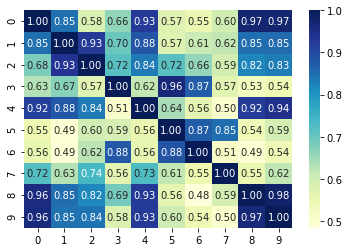

In [15]:
ax = sns.heatmap(Sfitness, cmap="YlGnBu", annot=True, fmt=".2f")

Compute RMSD between different conformers:

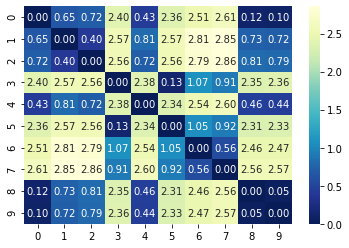

In [16]:
# Compute RMSD
scmols = [molecule.Molecule.from_rdkit(mol) for mol in cmols]

n = len(scmols)
RMSDs = np.zeros((n,n))

for i, mol1 in enumerate(scmols):
    for j, mol2 in enumerate(scmols):
        RMSDs[i,j] = rmsd.rmsdwrapper(mol1, mol2, minimize=True)[0]

ax = sns.heatmap(RMSDs, cmap="YlGnBu_r", annot=True, fmt=".2f")

Plot RMSD vs SENSAAS score to see if there is any correlation:

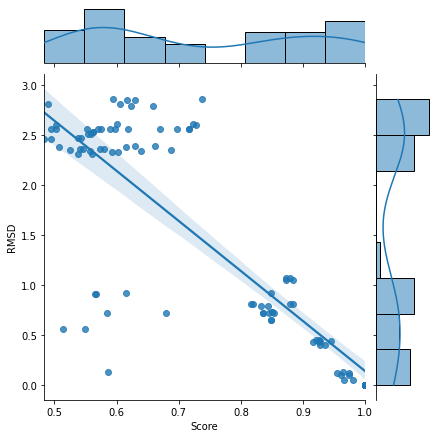

In [17]:
g = sns.jointplot(x=Sfitness.reshape(-1), y=RMSDs.reshape(-1),kind="reg")
g.set_axis_labels("Score", "RMSD")

Compute Pearson's correlation coefficient:

In [18]:
from scipy.stats import pearsonr
pearsonr(Sfitness.reshape(-1), RMSDs.reshape(-1))

(-0.8251026554464063, 4.854592771214903e-26)

There is clearly a strong correlation between the conformer RMSD and the alignment score.

In [19]:
als.show(0, 1)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
als.show(0, 2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [21]:
_ = widgets.interact(als.show, idx1=(0, len(mols) - 1), idx2=(0, len(mols) - 1))

interactive(children=(IntSlider(value=4, description='idx1', max=9), IntSlider(value=4, description='idx2', ma…